<h1>Lending Club Loan Prediction</h1>

## Introduction

- [Kaggle Link](https://www.lendingclub.com/personal-deposits)

- LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California. It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. LendingClub is the world's largest peer-to-peer lending platform.
- [Company link](https://www.lendingclub.com/personal-deposits)
-  In this case study, we will also develop a basic understanding of risk analytics in banking and financial services and understand how data is used to <b>minimise the risk of losing money</b> while lending to customers.

## Business Understanding
- **Objective:** Trying to reduce the number of defaulters!
- You work for the LendingClub company which specialises in lending various types of loans to urban customers. When the company receives a loan application, the company has to make a decision for loan approval based on the applicant’s profile. 
- For this usecase we are only going to access the dataset which were accepted by the company and try to detect the defaulters
- Based on our usecase, `loan_status` is crucial with the following values:
- - **Payers** Fully Paid, Current
- - **Defaulters** Charged Off, Late (31-120 days), In Grace Period, Late (16-30 days), Does not meet the credit policy. Status:Fully Paid, Does not meet the credit policy. Status:Charged Off, Default

- Based on the values available, we will categorize these into two: Payers, Defaulters. **Fully Paid, Current** are Payers and others are Defaulters.
- This is a binary classification model.

### Evaluation Metric
- **Recall:** The percentage of defaulters our model/tool was able to detect
- **Precision:** The prcentage of defaulters our model/tool predicted, how accurate are they
<br>
<br>
<i>**Based on the objective, recall is going to be the most crucial evaluation metric for my model since we are trying to detect as many defaulters as possible**</i>

## Data Walkthrough

In [1]:
#  Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [23]:
# TODO: Import from utils
def define_user_profile(loan_status):
    # Define user profile based on loan status
    if loan_status in ('Fully Paid', 'Current'):
        return 'Payer'
    else:
        return 'Defaulter'

In [24]:
df = pd.read_csv("../data/accepted_2007_to_2018Q4.csv")
# df['user_profile']  = df['loan_status'].apply(lambda x:'Payer' if(x in ('Fully Paid', 'Current')) else 'Defaulter') -> Lambda Function
df['user_profile']  = df['loan_status'].apply(define_user_profile)
df.drop(['loan_status'], axis=1, inplace=True) # inplace=True: modify the exisiting variable/dataframe that was passed
df.head()

/var/folders/3z/1gg3czrd2ps4jtgnrk_j_nqmgw5xwd/T/ipykernel_76711/3481089363.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/accepted_2007_to_2018Q4.csv")


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,user_profile
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Payer
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Payer
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Payer
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Payer
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Payer


In [25]:
df['user_profile'].value_counts()

user_profile
Payer        1955068
Defaulter     305633
Name: count, dtype: int64

## Data Ingestion

- FYI, to get data from the source directly rather than storing on the local
- Code:

import kagglehub
path = kagglehub.dataset_download("wordsforthewise/lending-club")
print("Path to dataset files:", path)

## EDA

- We are going to breakdown all/most important features that could be helpful to make our prediction
- Correlation between features and `user_profile`

### Columns to be examines

#### Bank relevant features
- `loan_amnt`: Loan Amount,
- `funded_amnt`: Total amount of the loan that has been disbursed to the borrower,
- `int_rate`: Interest rate,
- `installment`: Per Intallement,

- `term`: Loan term/timeperiod(preprocess to make it numeric),
- `pymnt_plan`: Payment plan,
- `issue_d`: The month/date the loan was funded,
- `grade`: Loan grade,
- `sub_grade`: Loan sub-grade,

- `purpose`: Loan purpose,
- `debt_settlement_flag`: Whether a borrower has settled their debt rather than paying it in full as per the original loan agreement,
- `verification_status`: Verification status of the borrower,
- `earliest_cr_line`: Earliest time the credit line of the borrower was openend,

#### Borrower features
- `emp_title`: Job title,
- `emp_length`: Borrower's work exp,
- `home_ownership`: Home Ownership of borrower,
- `annual_inc`: Annual Inc,
- `fico_range_low`: Low FICO Rating,
- `fico_range_high`: High FICO Rating,
- `dti`: Debt to income,

### Bank Features

#### Loan Amount, Funded Amount, Payment Plan, Installement

**Observations:**
- Loan amount and Funded amount are very similar in distribution, it would therefore makes sense to pick one among them
- More **Defaulters** for lesser installment amount(interestingly unlike what would be inuitive)
- More **Defaulters** on higher interest rate. This makeses sense because higher interest rate makes the total loan paid higher too.

<Axes: xlabel='int_rate', ylabel='Count'>

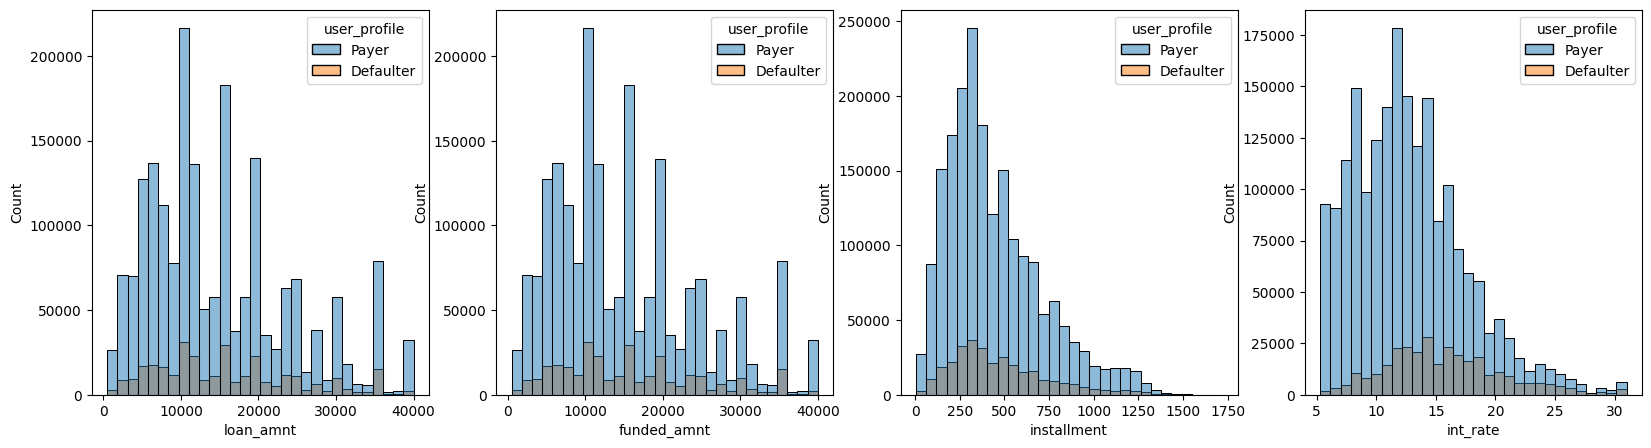

In [ ]:
# Create a figure
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot a histogram of loan amount
sns.histplot(df, x="loan_amnt", hue="user_profile", bins=30, ax=axes[0])

# Plot a histogram of funded amount
sns.histplot(df, x="funded_amnt", hue="user_profile", bins=30, ax=axes[1])

# Plot a histogram of funded amount
sns.histplot(df, x="installment", hue="user_profile", bins=30, ax=axes[2])

# Plot a histogram of interest rate
sns.histplot(df, x="int_rate", hue="user_profile", bins=30, ax=axes[3])

#### Term, Payment plan, Issue Date, Grade, Sub-grade

**Observations:**
- **Term and Payment plan** are binary features, which may not determine the cause of the borrower to default and so it may not be relevant for our prediction
- **Issue Date** we observe that the payers are increasing over time, but the defaulters around the year 2016 seem to default more and so it could be a crucial feature
- **Grade and Sub-grade**: These observations below prove that grade, sub grade are crucial
    1. Grade A borrowers are observed to default much lesser as compared to other loan grades
    2. Grade F, G have shown around ~40% of default rate
    3. Sub Grade C4, C5 are observed to be defaulting more than its peers in grade C

In [ ]:
df['term'].value_counts()

term
36 months    1609754
60 months     650914
Name: count, dtype: int64

In [ ]:
df['pymnt_plan'].value_counts()

pymnt_plan
n    2260048
y        620
Name: count, dtype: int64

In [ ]:
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['issue_d'].value_counts()

C:\Users\Kritika Selot\AppData\Local\Temp\ipykernel_8436\659230128.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['issue_d'] = pd.to_datetime(df['issue_d'])


issue_d
2016-03-01    61992
2015-10-01    48631
2018-05-01    46311
2018-10-01    46305
2018-08-01    46079
              ...  
2007-08-01       74
2007-07-01       63
2008-09-01       57
2007-09-01       53
2007-06-01       24
Name: count, Length: 139, dtype: int64

<Axes: xlabel='grade', ylabel='count'>

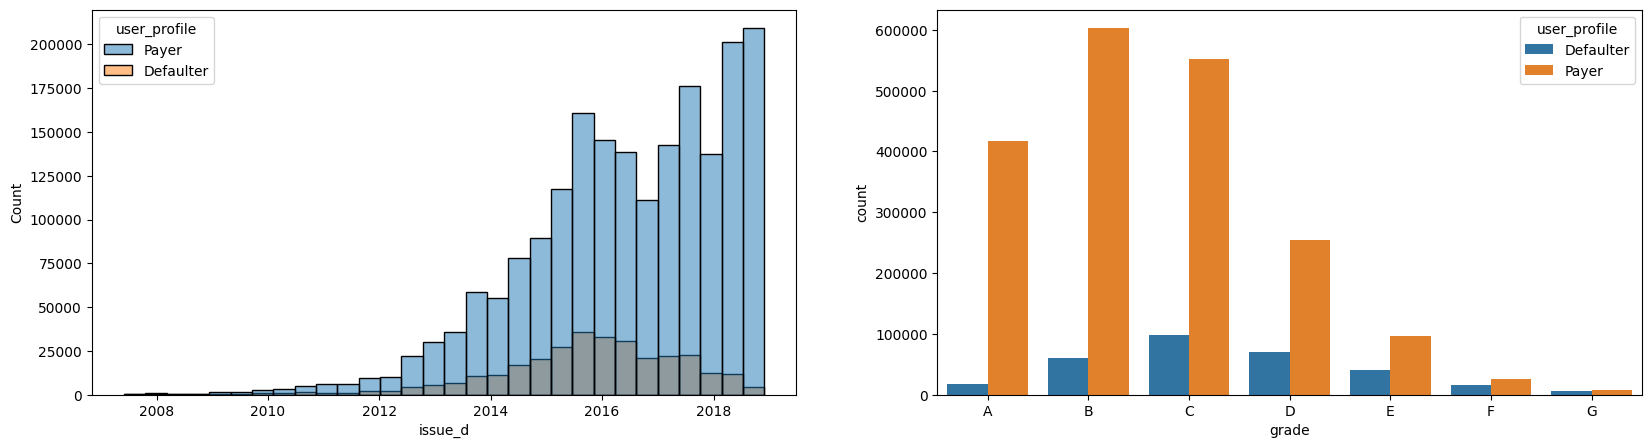

In [ ]:
# Create a figure
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Plot a histogram of issue date
sns.histplot(df, x="issue_d", hue="user_profile", bins=30, ax=axes[0])

# Plot a count plot for grade
sns.countplot(df.sort_values(["grade", "user_profile"]), x="grade", hue="user_profile", ax=axes[1])

<Axes: xlabel='sub_grade', ylabel='count'>

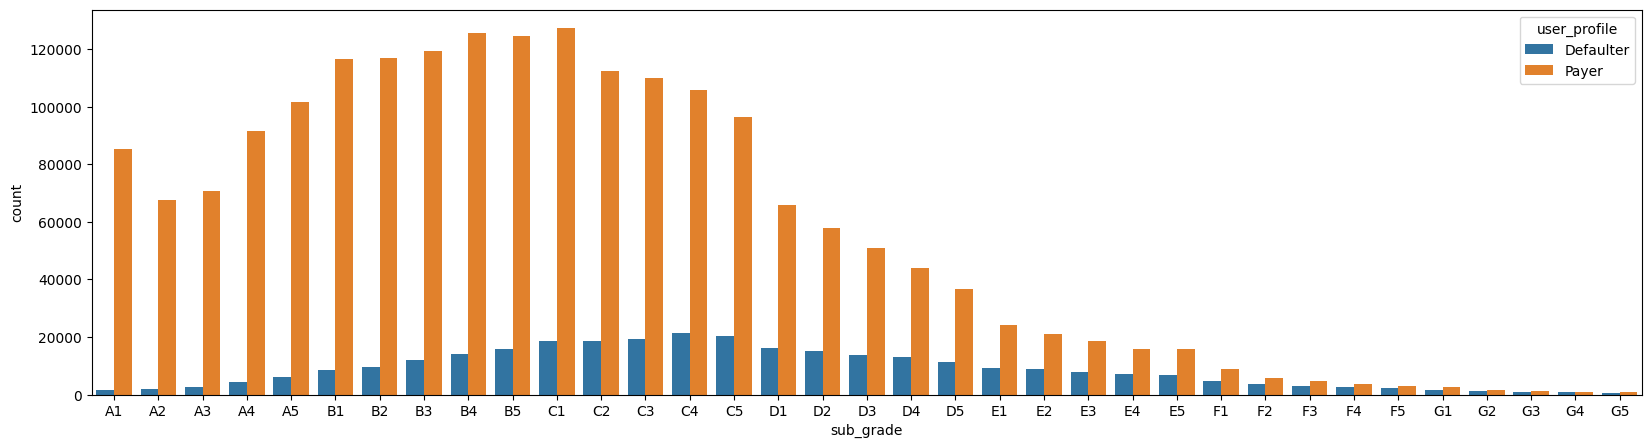

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
# Plot a count plot for sub grade
sns.countplot(df.sort_values(["sub_grade", "user_profile"]), x="sub_grade", hue="user_profile")

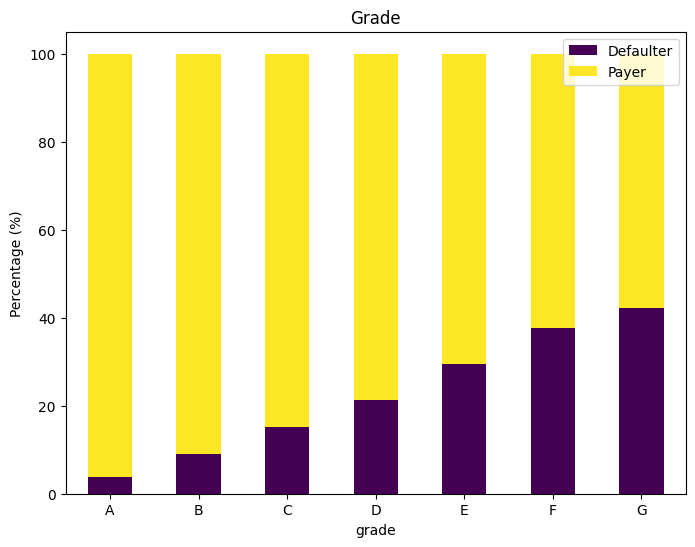

In [ ]:
# Stacked Bar Graph for Grade and User Profile

df_grade_group = df.groupby(["grade", "user_profile"]).size().unstack()

# Convert counts to percentages
df_percent = df_grade_group.div(df_grade_group.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
df_percent.plot(kind="bar", stacked=True, figsize=(8, 6), colormap="viridis")

# Move legend to the top-right
plt.legend(loc="upper right")

# Labels & Customization
plt.ylabel("Percentage (%)")
plt.title("Grade")
plt.xticks(rotation=0)
plt.show()

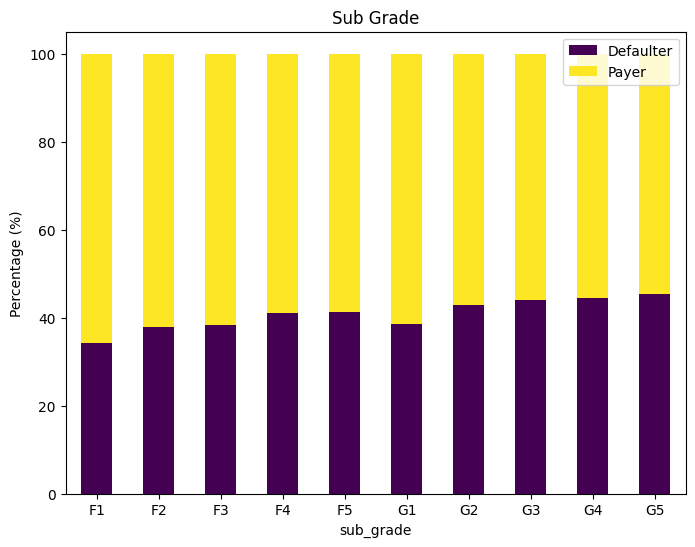

In [ ]:
# Stacked Bar Graph for Sub-grade and User Profile

df_grade_group = df[df['grade'].isin(['F', 'G'])].groupby(["sub_grade", "user_profile"]).size().unstack()

# Convert counts to percentages
df_percent = df_grade_group.div(df_grade_group.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
df_percent.plot(kind="bar", stacked=True, figsize=(8, 6), colormap="viridis")

# Move legend to the top-right
plt.legend(loc="upper right")

# Labels & Customization
plt.ylabel("Percentage (%)")
plt.title("Sub Grade")
plt.xticks(rotation=0)
plt.show()

#### Purpose, Debt Settlement Flag, Verification Status, Earliest Credit Line

**Observations:**
- **Purpose** could be a good feature since there are certain categories like `debt_consolidation` which has more chances of defaulting
- **Deb Settlement Flag**, the borrower who is flagged `yes` is most likely to default
- **Verification Status**, doesn't show any correlation to user profile
- **Earliest Credit Line**, it could be used as a feature but not very impactful.

In [ ]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
df['earliest_cr_line'].value_counts()

C:\Users\Kritika Selot\AppData\Local\Temp\ipykernel_8436\3916237658.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])


earliest_cr_line
2004-09-01    15400
2003-09-01    15215
2005-09-01    14780
2003-08-01    14669
2004-08-01    14413
              ...  
1957-02-01        1
1951-12-01        1
1952-11-01        1
1941-08-01        1
1946-12-01        1
Name: count, Length: 754, dtype: int64

<Axes: xlabel='verification_status', ylabel='count'>

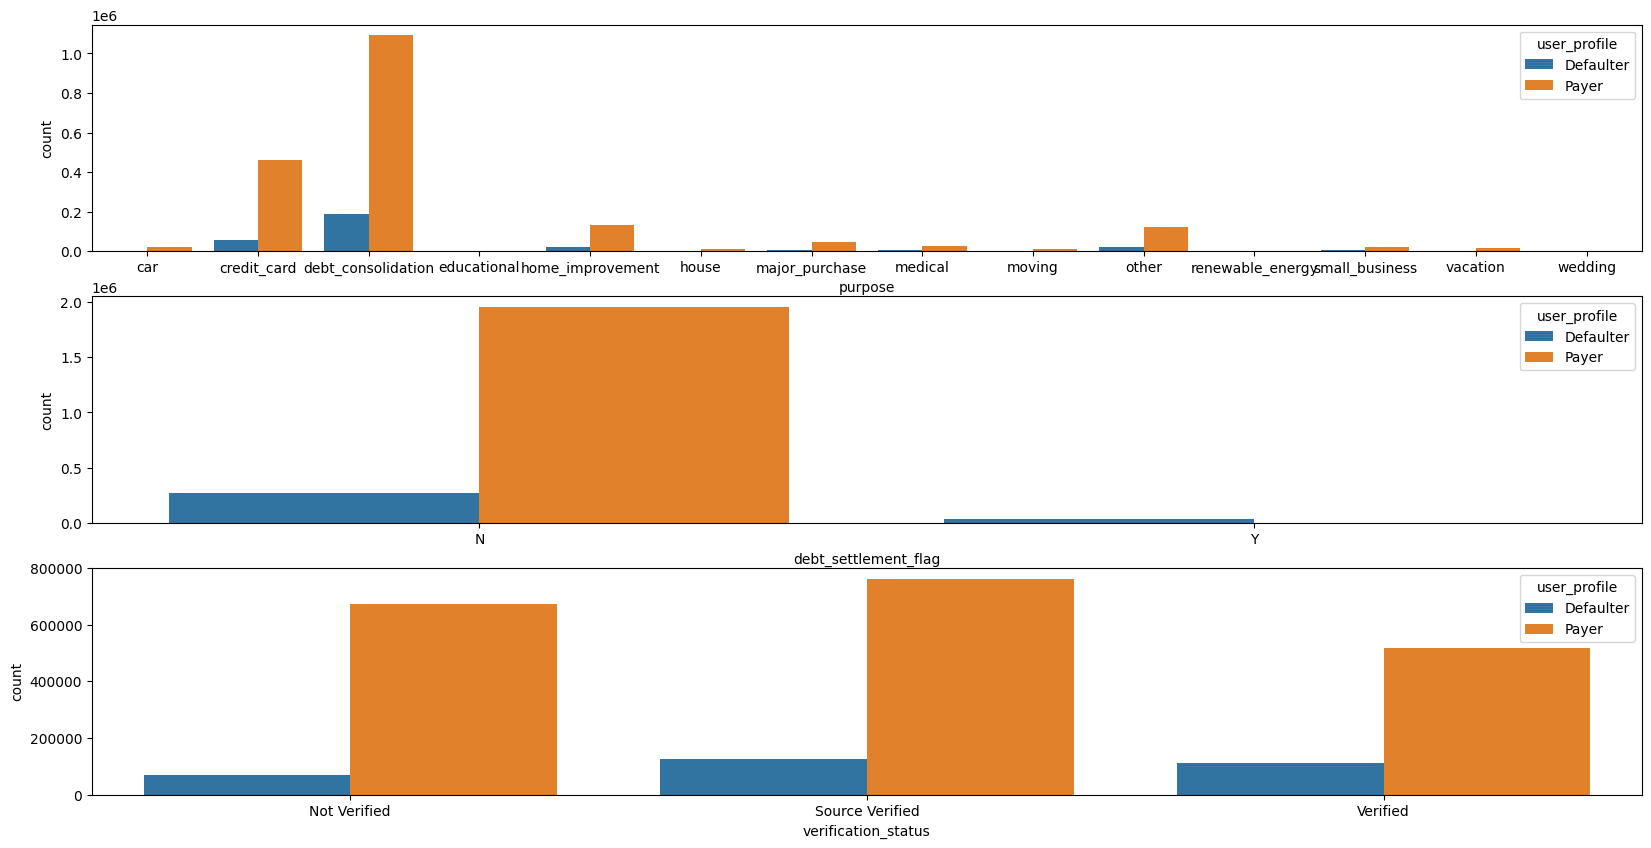

In [ ]:
# Create a figure
fig, axes = plt.subplots(3, figsize=(20, 10))

# Plot a count plot for purpose
sns.countplot(df.sort_values(["purpose", "user_profile"]), x="purpose", hue="user_profile", ax=axes[0])

# Plot a count plot for debt_settlement_flag
sns.countplot(df.sort_values(["debt_settlement_flag", "user_profile"]), x="debt_settlement_flag", hue="user_profile", ax=axes[1])

# Plot a count plot for verification_status
sns.countplot(df.sort_values(["verification_status", "user_profile"]), x="verification_status", hue="user_profile", ax=axes[2])

<Axes: xlabel='earliest_cr_line', ylabel='Count'>

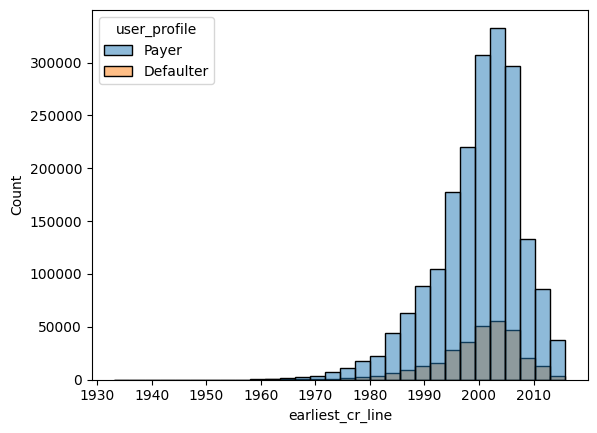

In [ ]:
# Plot a histogram of earliest_cr_line
sns.histplot(df, x="earliest_cr_line", hue="user_profile", bins=30)

### Borrower Features

#### Emp. title, Emp. Length/Experience, Home Ownership, Annual Incom

**Observations:**
- **Emp. title** has too many unique values, and would require too much pre-processing and not sure about its correlation to user profile(default)
- **Emp. Length**, not much correlation observed with user profile
- **Home Ownership**, `RENT` people tend to default more as compared to `MORTAGE`. `OWN` has much less default rate. So, this could be a relevant feature
- **Annual Income**, no observable correlation to user-profile.

In [5]:
df['emp_title'].value_counts()

emp_title
Teacher                                38824
Manager                                34298
Owner                                  21977
Registered Nurse                       15867
Driver                                 14753
                                       ...  
Electronic System Engineer                 1
Substitute Teacher/Paraprofessional        1
eligiblity worker                          1
Escalated Customer Service Advisor         1
Current Operations Officer                 1
Name: count, Length: 512694, dtype: int64

In [11]:
df['emp_length'].value_counts()

emp_length
10+ years    748005
2 years      203677
< 1 year     189988
3 years      180753
1 year       148403
5 years      139698
4 years      136605
6 years      102628
7 years       92695
8 years       91914
9 years       79395
Name: count, dtype: int64

<Axes: xlabel='home_ownership', ylabel='count'>

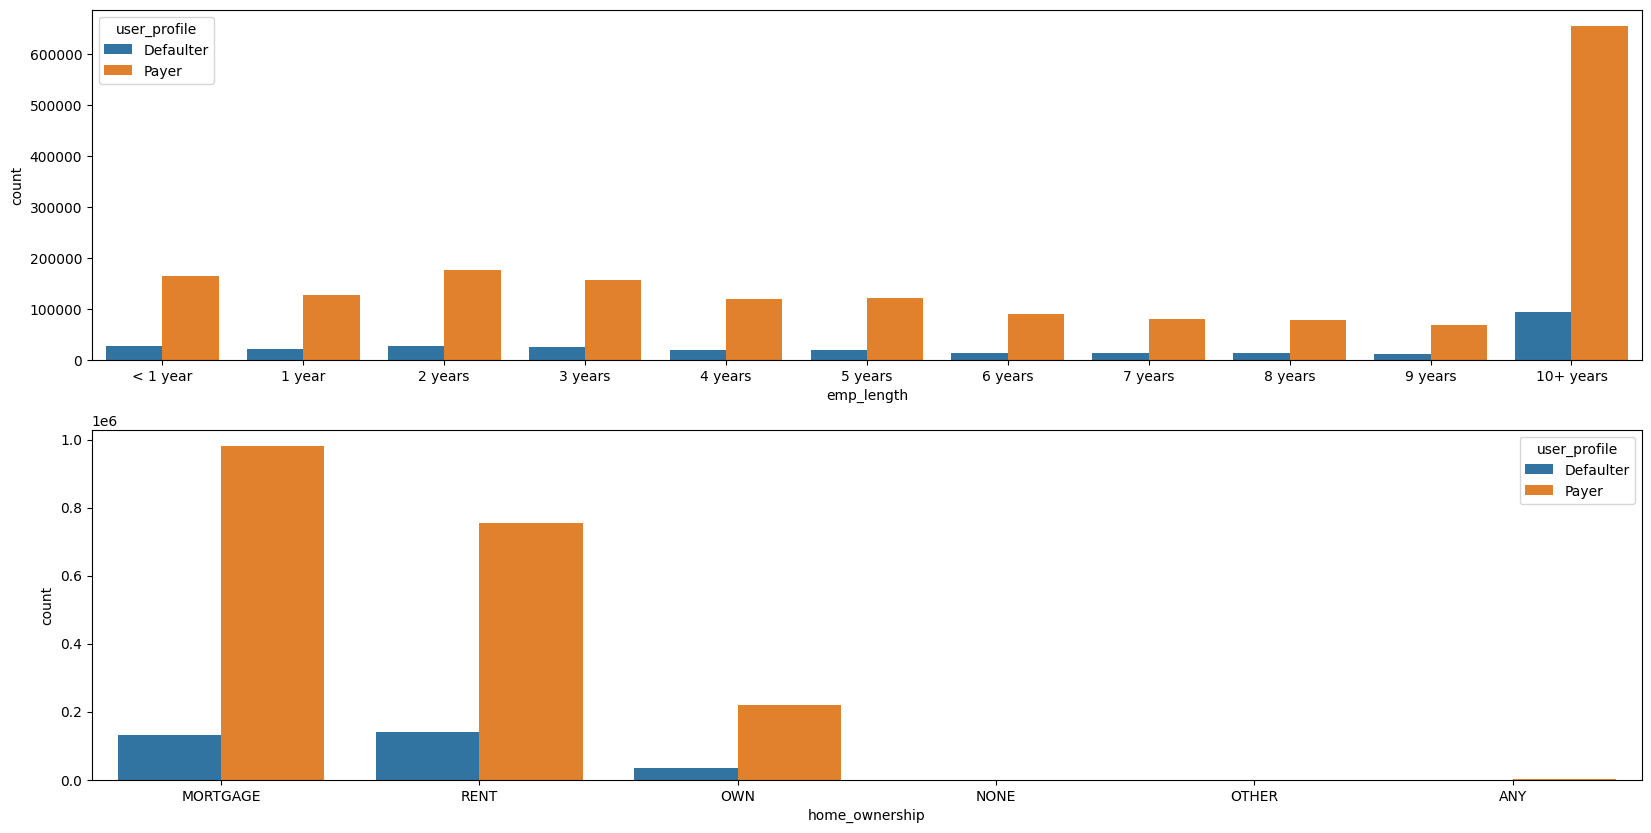

In [31]:
# Create a figure
fig, axes = plt.subplots(2, figsize=(20, 10))

# Plot a count plot for purpose
sns.countplot(df.sort_values("user_profile"), x="emp_length", hue="user_profile", 
              order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years','7 years','8 years', '9 years', '10+ years'], 
              ax=axes[0])

# Plot a count plot for debt_settlement_flag
sns.countplot(df.sort_values("user_profile"), x="home_ownership", hue="user_profile", ax=axes[1])

<Axes: xlabel='log_annual_inc', ylabel='Count'>

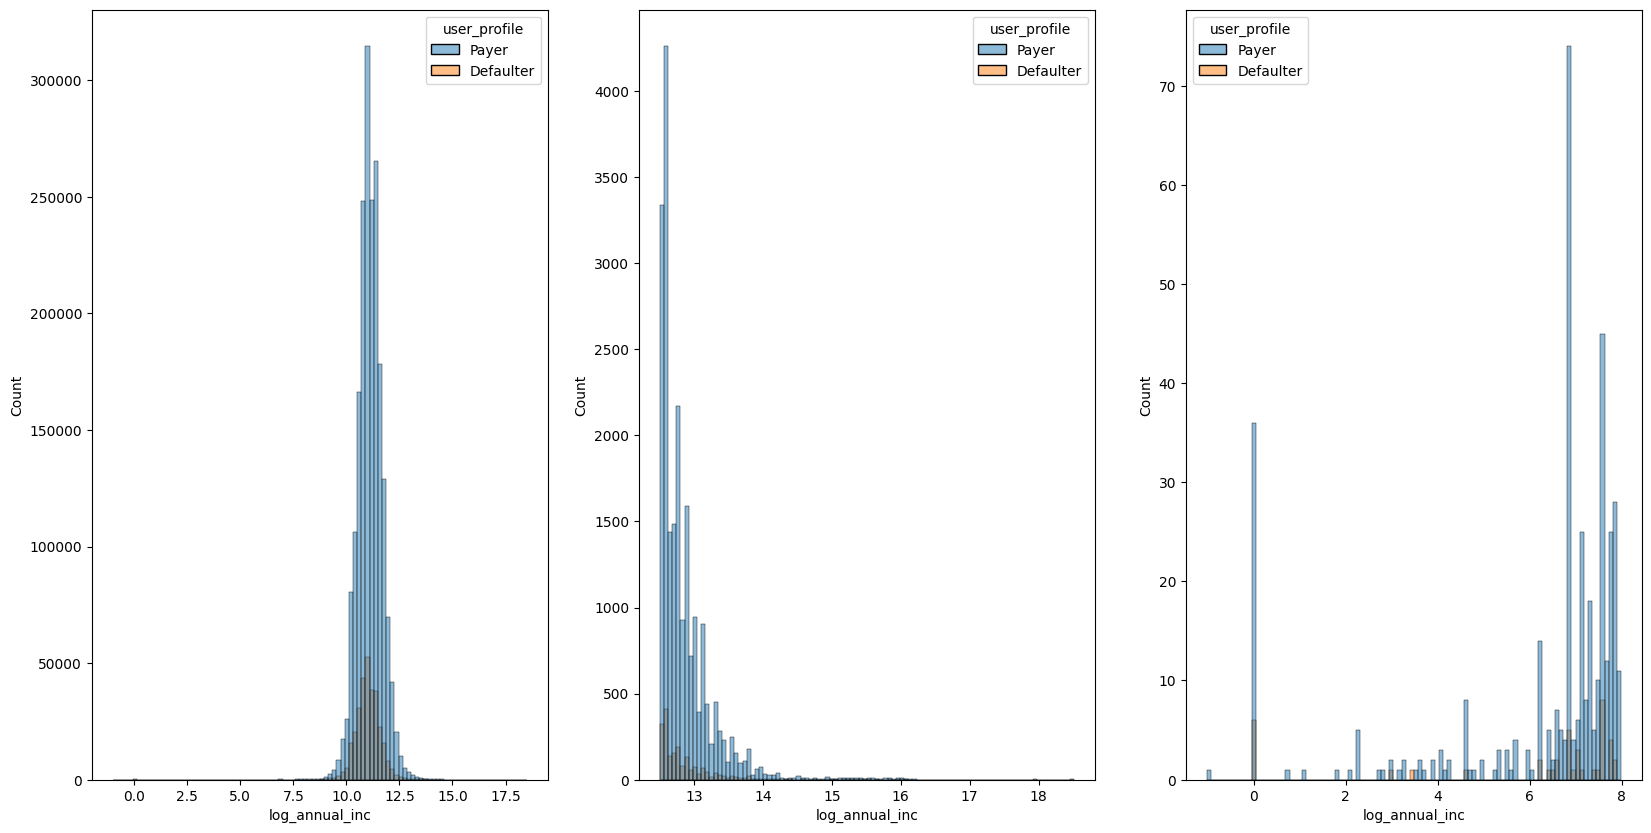

In [36]:
# Create a figure
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

df['log_annual_inc'] = df['annual_inc'].apply(np.log)
sns.histplot(df, x="log_annual_inc", hue="user_profile", bins=100, ax=axes[0])

high_earning_df = df[df['log_annual_inc'] > 12.5]
sns.histplot(high_earning_df, x="log_annual_inc", hue="user_profile", bins=100, ax=axes[1])

low_earning_df = df[df['log_annual_inc'] < 8]
sns.histplot(low_earning_df, x="log_annual_inc", hue="user_profile", bins=100, ax=axes[2])


#### FICO Rating, DTI(Debt to Icome)


**Observations:**
- **FICO Low/High Range**: Any low/high fico range greater 750 are observed to default significantly less
- **DTI**: Higher DTI is leaning to more default than payment.

<Axes: xlabel='dti_capped', ylabel='Count'>

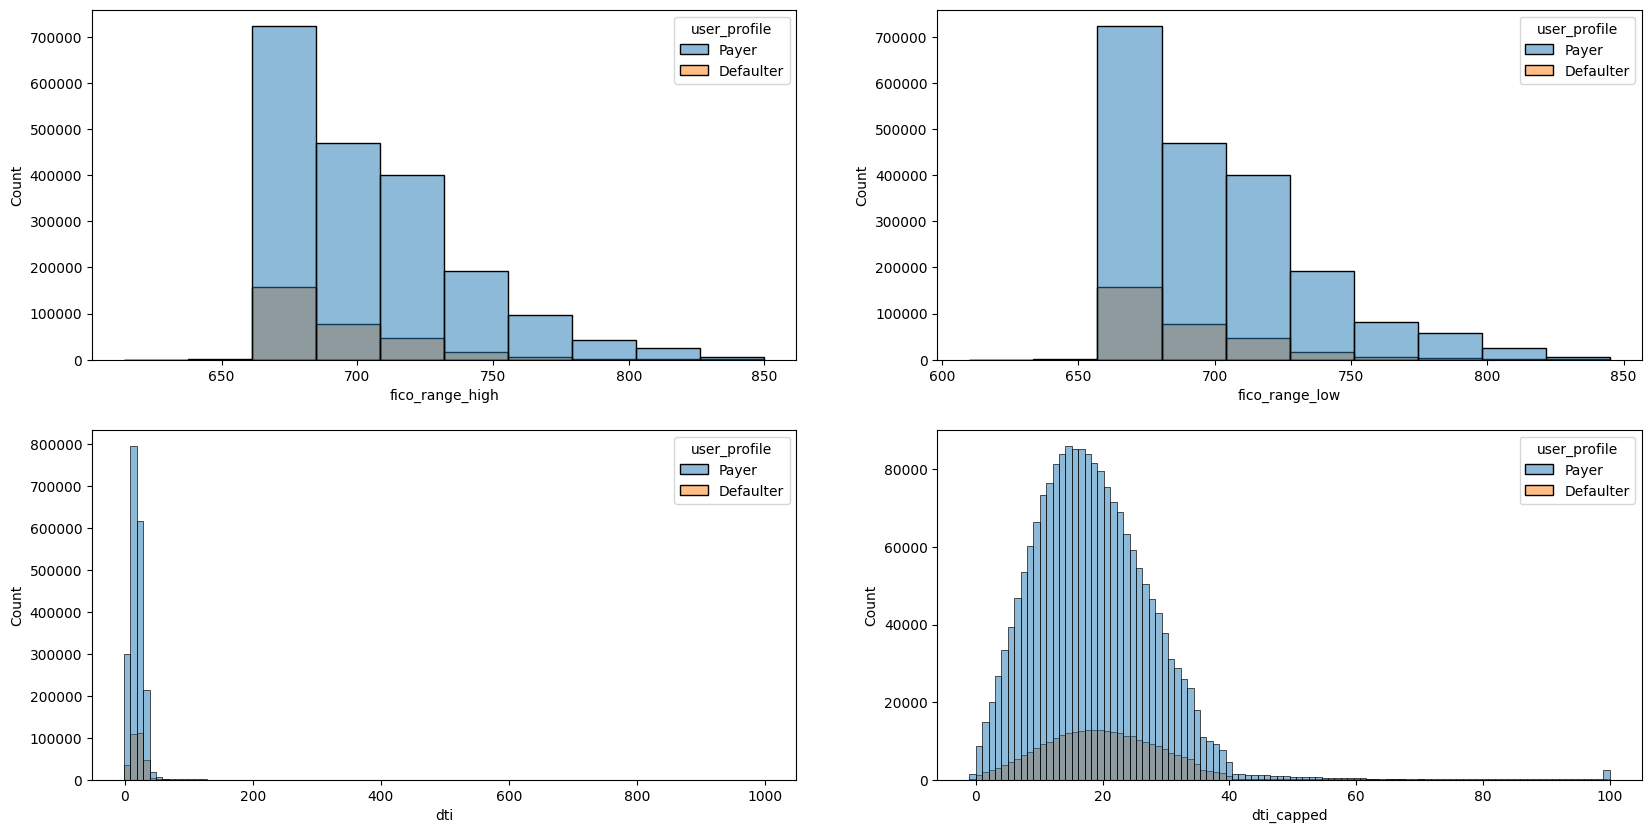

In [49]:
df['dti_capped'] = df['dti'].apply(lambda x: 100 if x > 100 else x)
# Create a figure
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Plot a histogram of fico_range_high
sns.histplot(df, x="fico_range_high", hue="user_profile", bins=10, ax=axes[0, 0])

# Plot a histogram of fico_range_low
sns.histplot(df, x="fico_range_low", hue="user_profile", bins=10, ax=axes[0, 1])

# Plot a histogram of dti
sns.histplot(df, x="dti", hue="user_profile", bins=100, ax=axes[1, 0])

# Plot a histogram of dti_capped
sns.histplot(df, x="dti_capped", hue="user_profile", bins=100, ax=axes[1, 1])

In [50]:
df_continuous = df[['loan_amnt', 'funded_amnt', 'installment', 'int_rate', 'log_annual_inc', 'fico_range_high', 'fico_range_low', 'dti', 'dti_capped', 'user_profile']]
df_continuous = pd.get_dummies(df_continuous, columns=["user_profile"], dtype=int)
df_continuous.head()

,loan_amnt,funded_amnt,installment,int_rate,log_annual_inc,fico_range_high,fico_range_low,dti,dti_capped,user_profile_Defaulter,user_profile_Payer
0,3600.0,3600.0,123.03,13.99,10.915088,679.0,675.0,5.91,5.91,0,1
1,24700.0,24700.0,820.28,11.99,11.082143,719.0,715.0,16.06,16.06,0,1
2,20000.0,20000.0,432.66,10.78,11.050890,699.0,695.0,10.78,10.78,0,1
3,35000.0,35000.0,829.90,14.85,11.608236,789.0,785.0,17.06,17.06,0,1
4,10400.0,10400.0,289.91,22.45,11.556301,699.0,695.0,25.37,25.37,0,1


### Continuous features vs User Profile

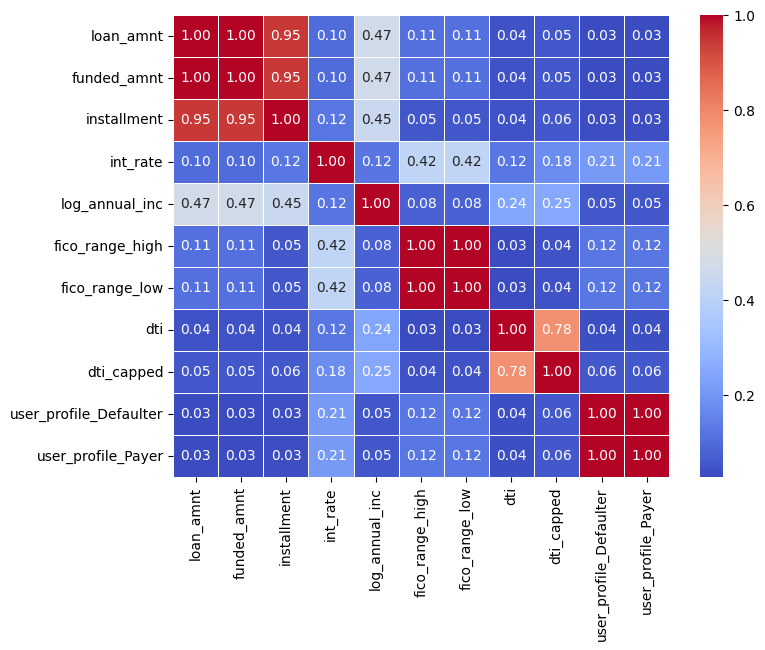

In [53]:
# Compute correlation matrix
corr_matrix = df_continuous.corr().abs()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Display plot
plt.show()